In [119]:
import math
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
import torchtext.transforms as T
from torch import nn
from torch.utils.data import DataLoader
from torchlake.common.schemas import NlpContext
from torchlake.common.utils.text import build_vocab
from torchlake.sequence_data.models import (Seq2Seq, Seq2SeqDecoder,
                                            Seq2SeqEncoder)
from torchtext.data.utils import get_tokenizer
from torchtext.datasets import Multi30k
from tqdm import tqdm

# setting

In [120]:
data_path = Path("../../data/multi30k")
artifacts_path = Path("../../artifacts/seq2seq")

In [121]:
BATCH_SIZE = 32
context = NlpContext()

In [122]:
device = torch.device(context.device)

# data

In [123]:
SRC_LANGUAGE = 'de'
TRG_LANGUAGE = 'en'

In [124]:
tokenizers = {
    SRC_LANGUAGE: get_tokenizer('spacy', language=SRC_LANGUAGE), # de_core_news_sm
    TRG_LANGUAGE: get_tokenizer('spacy', language=TRG_LANGUAGE)  # en_web_core_sm
}

d:\research\pytorch-implementations\.venv\Lib\site-packages\torchtext\data\utils.py:105: UserWarning: Spacy model "de" could not be loaded, trying "de_core_news_sm" instead
  warnings.warn(


d:\research\pytorch-implementations\.venv\Lib\site-packages\torchtext\data\utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(


In [125]:
train_iter, val_iter, test_iter = Multi30k(
    data_path.as_posix(),
    language_pair=(SRC_LANGUAGE, TRG_LANGUAGE),
)

In [126]:
vocabs = {
    SRC_LANGUAGE: build_vocab(map(lambda x: tokenizers[SRC_LANGUAGE](x[0]), train_iter), context),
    TRG_LANGUAGE: build_vocab(map(lambda x: tokenizers[SRC_LANGUAGE](x[1]), train_iter), context),
}

d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\iter\combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


In [127]:
src_transform = T.Sequential(
    T.VocabTransform(vocabs[SRC_LANGUAGE]),
    T.Truncate(context.max_seq_len - 2),
    T.AddToken(token=context.bos_idx, begin=True),
    T.AddToken(token=context.eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(context.max_seq_len, context.padding_idx),
)

trg_transform = T.Sequential(
    T.VocabTransform(vocabs[TRG_LANGUAGE]),
    T.Truncate(context.max_seq_len - 2),
    T.AddToken(token=context.bos_idx, begin=True),
    T.AddToken(token=context.eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(context.max_seq_len, context.padding_idx),
)

In [128]:
def collate_fn(batch):
    src_batch, tgt_batch = [], []

    for src_sample, trg_sample in batch:
        # paper p.2: reverse source sentence
        src_sample = src_sample[::-1]
        
        src_tokenizer  = tokenizers[SRC_LANGUAGE]
        src_batch.append(src_transform(src_tokenizer(src_sample.rstrip("\n"))))
        
        trg_tokenizer  = tokenizers[TRG_LANGUAGE]
        tgt_batch.append(trg_transform(trg_tokenizer(trg_sample.rstrip("\n"))))

    return torch.stack(src_batch), torch.stack(tgt_batch)

In [129]:
train_loader = DataLoader(
    train_iter,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn,
)

In [130]:
for src, trg in train_loader:
    print(src.shape, trg.shape)
    break

torch.Size([32, 256]) torch.Size([32, 256])


In [131]:
vocab_sizes = {
    SRC_LANGUAGE: len(vocabs[SRC_LANGUAGE]),
    TRG_LANGUAGE: len(vocabs[TRG_LANGUAGE]),
}

# Model

In [132]:
encoder = Seq2SeqEncoder(
    vocab_sizes[SRC_LANGUAGE],
    128,
    128,
    context=context,
).to(device)

decoder = Seq2SeqDecoder(
    vocab_sizes[TRG_LANGUAGE],
    128,
    128,
    output_size=vocab_sizes[TRG_LANGUAGE],
    context=context,
).to(device)

model = Seq2Seq(encoder, decoder, context).to(device)

In [133]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
Seq2Seq                                  --
├─Seq2SeqEncoder: 1-1                    --
│    └─LstmClassifier: 2-1               --
│    │    └─Embedding: 3-1               464,640
│    │    └─LSTM: 3-2                    132,096
│    │    └─LayerNorm: 3-3               256
│    │    └─Linear: 3-4                  129
├─Seq2SeqDecoder: 1-2                    --
│    └─LstmClassifier: 2-2               --
│    │    └─Embedding: 3-5               430,720
│    │    └─LSTM: 3-6                    132,096
│    │    └─LayerNorm: 3-7               256
│    │    └─Linear: 3-8                  434,085
Total params: 1,594,278
Trainable params: 1,594,278
Non-trainable params: 0

# Training

In [134]:
criterion = nn.CrossEntropyLoss(ignore_index = context.padding_idx)
optimizer = torch.optim.Adam(model.parameters())

In [135]:
epoches = 10

In [136]:
model.train()
training_loss = []
for e in range(epoches):
    running_loss = 0.0
    data_count = 0
    
    for source_sentence, target_sentence in tqdm(train_loader):
        data_count += len(source_sentence)
        optimizer.zero_grad()

        text = source_sentence.to(device)
        label = target_sentence.to(device)
        # label = label[:, 1:].view(-1)

        output = model(text, label)
        # output = torch.flatten(output[:, 1:], end_dim=-2)
        loss = criterion(output.transpose(-1, -2), label)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

    mean_loss = running_loss / data_count
    training_loss.append(mean_loss)
    print(f"epoch {e+1} : {mean_loss}")

905it [01:22, 11.77it/s]d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\_jit_internal.py:1355: UserWarning: The inner type of a container is lost when calling torch.jit.isinstance in eager mode. For example, List[int] would become list and therefore falsely return True for List[float] or List[str].
  warnings.warn(
907it [01:22, 11.02it/s]


epoch 1 : 0.017756800946238854


907it [01:20, 11.32it/s]


epoch 2 : 0.0002230972870818898


907it [01:19, 11.40it/s]


epoch 3 : 3.8360028107649006e-05


907it [01:21, 11.14it/s]


epoch 4 : 1.647737256033482e-05


907it [01:17, 11.67it/s]


epoch 5 : 8.495792418167656e-06


907it [01:21, 11.09it/s]


epoch 6 : 4.731972046688728e-06


907it [01:22, 10.93it/s]


epoch 7 : 2.7489773836100455e-06


907it [01:21, 11.16it/s]


epoch 8 : 1.6379637361007078e-06


907it [01:18, 11.54it/s]


epoch 9 : 9.922805569780704e-07


907it [01:21, 11.18it/s]

epoch 10 : 6.091692144126171e-07


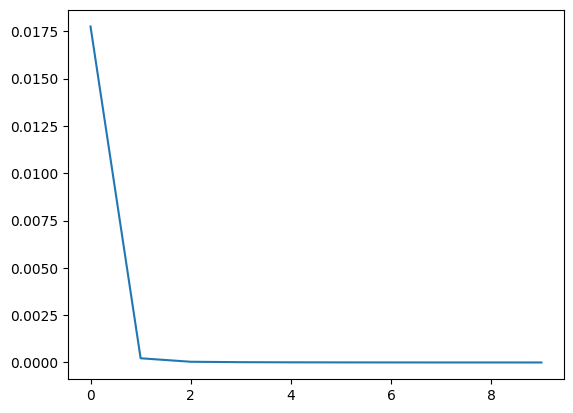

In [137]:
plt.plot(training_loss)

# Evaluate

In [138]:
test_loader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

In [140]:
model.eval()
running_loss = 0.0
data_count = 0
with torch.no_grad():
    for source_sentence, target_sentence in tqdm(test_loader):
        data_count += len(source_sentence)
        text = source_sentence.to(device)
        label = target_sentence.to(device)
        # label = label[1:].view(-1)

        output = model(text, label, 0)
        # output = torch.flatten(output[:, 1:], end_dim=-2)

        loss = criterion(output.transpose(-1, -2), label)
        running_loss += loss.item()

    mean_loss = running_loss / data_count

print(f"loss: {mean_loss}")
print(f"perplexity: {math.exp(mean_loss)}")

32it [00:02, 11.47it/s]

loss: 4.618349534919912e-07
perplexity: 1.0000004618350602


# Translate

In [141]:
MAX_LENGTH = 100

model.eval()
with torch.no_grad():
    for i, (source_sentence, target_sentence) in enumerate(val_iter):
        ori_source, ori_target = source_sentence, target_sentence
        source_sentence = tokenizers[SRC_LANGUAGE](source_sentence.rstrip('\n'))
        source_sentence = src_transform(source_sentence)
        source_sentence = source_sentence.unsqueeze(0)
        source_sentence = source_sentence.to(device)
        
        target_sentence = tokenizers[TRG_LANGUAGE](target_sentence.rstrip('\n'))
        target_sentence = trg_transform(target_sentence)
        target_sentence = target_sentence.unsqueeze(0)
        target_sentence = target_sentence.to(device)
        
        # outputs = [BOS_IDX]
        
        # h, c = model.encoder(source_sentence)
        
        # for _ in range(MAX_LENGTH):
            
        #     input_seq = torch.LongTensor([outputs[-1]]).to(device)
            
        #     output, _, _ = model.decoder(input_seq, h, c)
            
        #     next_token = output.argmax(1).item()
        #     outputs.append(next_token) 
            
        #     if next_token == EOS_IDX: break
        
        output = model(source_sentence, target_sentence)[0].argmax(-1)
        
        # if EOS_IDX in outputs:
        translated = vocabs[TRG_LANGUAGE].lookup_tokens(output.tolist())
        print(f'第{i+1}句')
        print(ori_source.rstrip('\n'))
        print(ori_target.rstrip('\n'))
        print(*translated,sep=' ')
        
        if i==10: break

第1句
Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen
A group of men are loading cotton onto a truck
<bos> A group of men are loading cotton onto a truck <eos> . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
第2句
Ein Mann schläft in einem grünen Raum auf einem Sofa.
A man sleeping in a green room on a couch.
<bos> A man sleeping in a green room on a couch . <eos> . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [142]:
model_path = artifacts_path / 'seq2seq.pth'

In [143]:
torch.save(model, model_path.as_posix())

In [17]:
model = torch.load(model_path.as_posix())